# Chapter 4. Regression and Prediction

필요한 패키지들을 설치 및 불러오기 합니다.

In [1]:
!pip install pygam
!pip install dmba

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

import scipy.stats as stats

데이터를 불러오기 위한 경로를 설정합니다. 반드시 필요한 csv 파일이 경로 상에 위치해야 파일을 불러올 수 있습니다.

In [3]:
DATA = "C:/Users/jmjwj/workspace/HD/"

In [4]:
HOUSE_CSV = DATA + '/house_sales.csv'

In [5]:
house = pd.read_csv(HOUSE_CSV, sep = '\t')
house.head()
house.columns

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction'],
      dtype='object')

## Model Selection

In [6]:
# 예측변수와 반응변수 설정

predictors = ['SqFtTotLiving', 'SqFtLot',  'Bathrooms', 
              'Bedrooms', 'BldgGrade',  
              'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt', 
              'YrRenovated', 'NewConstruction']
outcome = 'AdjSalePrice'

#범주형 변수를 더미변수화,
X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
Y = house[outcome]

# 절편항추가
X = sm.add_constant(X)

#모델적합
house_full = sm.OLS(house[outcome], X)
results = house_full.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     3307.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:55:15   Log-Likelihood:            -3.1379e+05
No. Observations:               22687   AIC:                         6.276e+05
Df Residuals:                   22676   BIC:                         6.277e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.923e+06   1.46e+05     40.470      0.000    5.64e+06    6.21e+06
SqFtTotLiving     186.3830      3.977     46.861      0.000     178.587     194.179
SqFtLot             0.0598      0.058      1.031      0.302      -0.054       0.173
Bathrooms        4.866e+04   3753.060     12.965      0.000    4.13e+04     5.6e+04
Bedrooms        -5.516e+04   2369.369    -23.282      0.000   -5.98e+04   -5.05e+04
BldgGrade         1.41e+05   2403.353     58.662      0.000    1.36e+05    1.46e+05
NbrLivingUnits  -5456.0320   1.07e+04     -0.512      0.609   -2.63e+04    1.54e+04
SqFtFinBasement    14.3497      4.554      3.151      0.002       5.423      23.277
YrBuilt         -3423.4700     75.309    -45.459      0.000   -3571.080   -3275.860
YrRenovated        -1.1177      3.926     -0.285      0.776      -8.814       6.579
NewConstruction  7895.6838   5815.717      1.358      0.175   -3503.520    1.93e+04
==============================================================================
Omnibus:                    31103.422   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26624089.276
Skew:                           7.471   Prob(JB):                         0.00
Kurtosis:                     170.158   Cond. No.                     2.81e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
#dmba패키지의 stepwise selection 사용

y = house[outcome]

#모델 train 시키기
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

# 각 모델의 AIC score을 출력하도록 하는 함수.
def score_model(model, variables):
    # 설명변수를 넣지 않았다면, 상수항(y의 평균)만 포함되는 모델의 AIC를 출력
    if len(variables) == 0:
        return AIC_score(y, [y.mean()]*len(y), model, df = 1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose = True)

print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')

#stepwise selection에 따른 최적모델 출력
for name,coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: const, SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627594.61, add SqFtFinBasement
Step: score=627594.61, unchanged None
Intercept: 5838868.286
Coefficients:
 SqFtTotLiving: 187.12320357801494
 BldgGrade: 140987.9223588172
 YrBuilt: -3382.546035708973
 Bedrooms: -55611.07850174252
 Bathrooms: 48249.58144060304
 SqFtFinBasement: 14.05750043434176


In [8]:
X[best_variables]
X = sm.add_constant(X[best_variables])

stepwise = sm.OLS(house[outcome], X)
results = stepwise.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     5512.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:55:16   Log-Likelihood:            -3.1379e+05
No. Observations:               22687   AIC:                         6.276e+05
Df Residuals:                   22680   BIC:                         6.276e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.839e+06    1.3e+05     45.000      0.000    5.58e+06    6.09e+06
SqFtTotLiving     187.1232      3.921     47.722      0.000     179.438     194.809
BldgGrade         1.41e+05   2387.112     59.062      0.000    1.36e+05    1.46e+05
YrBuilt         -3382.5460     67.835    -49.864      0.000   -3515.508   -3249.584
Bedrooms        -5.561e+04   2344.669    -23.718      0.000   -6.02e+04    -5.1e+04
Bathrooms        4.825e+04   3654.284     13.204      0.000    4.11e+04    5.54e+04
SqFtFinBasement    14.0575      4.537      3.098      0.002       5.164      22.951
==============================================================================
Omnibus:                    31081.489   Durbin-Watson:                   1.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26521648.191
Skew:                           7.461   Prob(JB):                         0.00
Kurtosis:                     169.835   Cond. No.                     2.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Testing the Assumptions: Regression Diagnostics
## Outliers

In [9]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade','SqFtFinBasement']
outcome = 'AdjSalePrice'
# 예측변수와 종속변수를 설정하자.

house_model = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_model.fit()
#회귀모델 적합

print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     214.4
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          1.95e-106
Time:                        14:55:16   Log-Likelihood:                -4216.2
No. Observations:                 313   AIC:                             8446.
Df Residuals:                     306   BIC:                             8473.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
SqFtTotLiving     288.0982     29.544     

`OLSInfluence` class는 회귀모델의 결과값을 인자로 받아, studentized residuals를 반환합니다.

In [10]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min()) # sresiduals의 minimum 

24333 -4.956533145396898


outlier 에 해당하는 datapoint 값을 확인해봅니다.

In [11]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving      2900
SqFtLot            7276
Bathrooms           3.0
Bedrooms              6
BldgGrade             7
SqFtFinBasement     320
Name: 24333, dtype: object


## Influential values

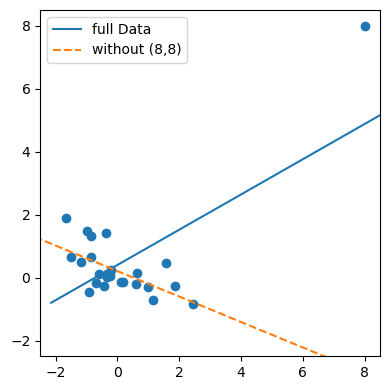

In [12]:
%matplotlib inline
from scipy.stats import linregress

#(X,y) 데이터셋을 생성
np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
#Influential Value를 임의로 생성
x[0] = 8
y[0] = 8

# 직선의 각 point의 좌표를 출력하는 함수
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)



fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y) # 데이터 포인트 산점도
slope, intercept, _, _, _ = linregress(x, y)# Y~X 회귀직선 적합.
ax.plot(*abline(slope, intercept, ax), label = "full Data")
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--', label = "without (8,8)")
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#cook's distance가 0.08이상이면 influential point라고 생각하고, 
# 이들을 포함하고 모델링 한 것과 제거하고 모델링 한 것의 차이를 보자.

mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,288.098239,290.657684
SqFtLot,34.975569,29.575592
Bathrooms,-5936.894104,-20124.656978
Bedrooms,-29695.083213,-24505.202040
BldgGrade,110315.325427,98711.665682
SqFtFinBasement,-145.463292,-114.595848
const,-661989.047015,-559039.062033


## Heteroskedasticity, Non-Normality

`regplot`을 사용해서 residual plot을 쉽게 그릴 수 있습니다.

< heteroskedasticity > - 이분산성

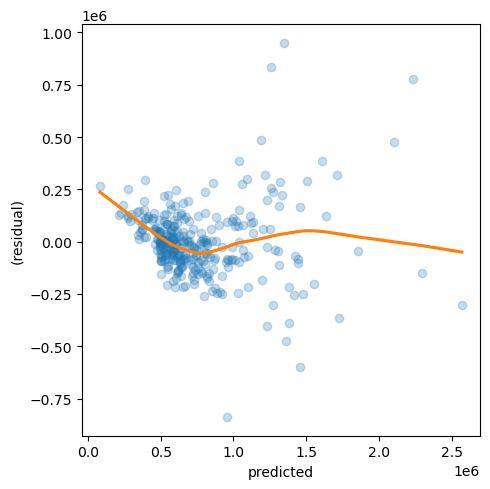

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(x=result_98105.fittedvalues, y=result_98105.resid, 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax) #잔차플롯
ax.set_xlabel('predicted')
ax.set_ylabel('(residual)')

plt.tight_layout()
plt.show()

< non-normality >

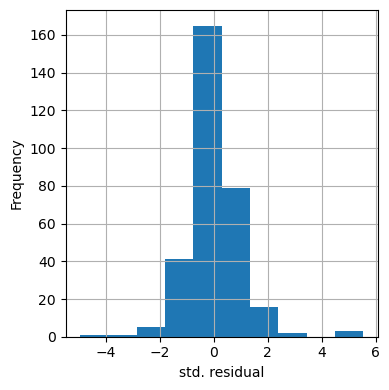

In [15]:
# 그 다음으로 선형회귀의 또 다른 가정인, 
# 주어진 데이터 Y가 정규성을 따르는 지에 대하여도 알아보자 
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
#표준화잔차의 정규성 확인
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

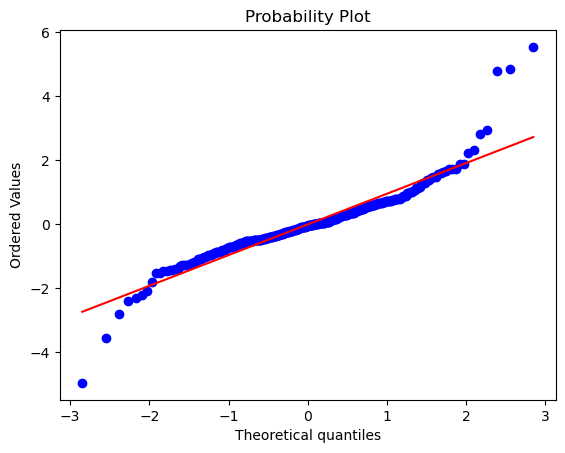

In [16]:
fig, ax = plt.subplots()
stats.probplot(influence.resid_studentized_internal, plot=ax)
plt.show()

## Partial Residual Plots and Nonlinearity

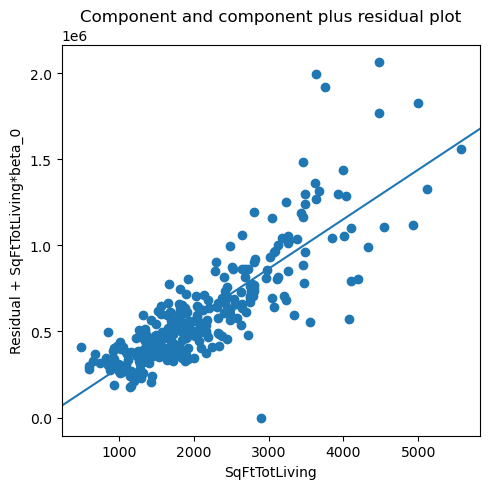

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

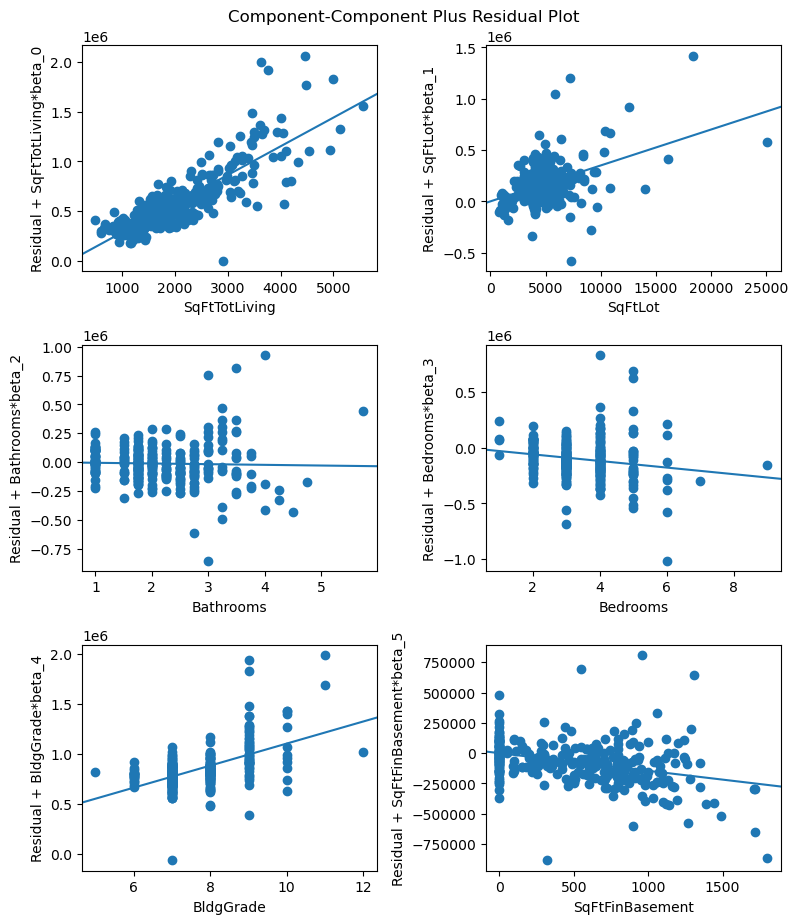

In [18]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## Polynomial and Spline Regression

In [19]:
# 위의 편잔차 플롯에서 확인한 비선형성을 회귀모델에 적용시키기 위한 방법으로,
# 다항회귀와 스플라인 회귀가 있다.

#다항회귀 적합
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          9.95e-106
Time:                        14:55:18   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [20]:

#다항식 고려 안한모델
model_origin= smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
#np.power을 활용하여, SqFtTotLiving 변수의 제곱항도 회귀식에 포함시키자.
result_origin = model_origin.fit()
print(result_origin.summary())


                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          1.69e-103
Time:                        14:55:18   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.725e+05   9.83e+04     -7.861

파이썬에서 plot_ccpr를 이용하여 편잔차플롯을 그릴 때엔 오직 선형항에 대해서만 작용하는데, polynomial항에 대해서도 그릴 수 있도록 코드를 짜 보았다.

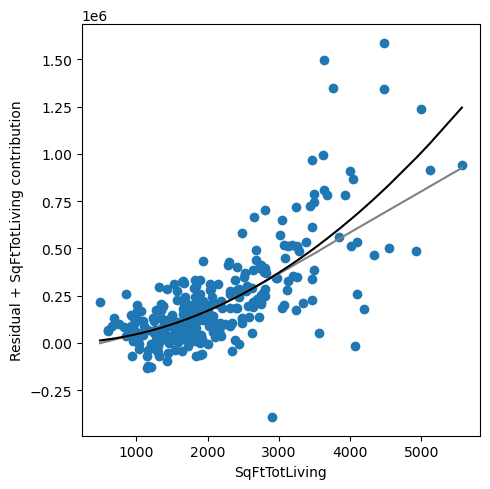

0.03879128168236591


In [21]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Splines

In [22]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          7.10e-104
Time:                        14:55:18   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


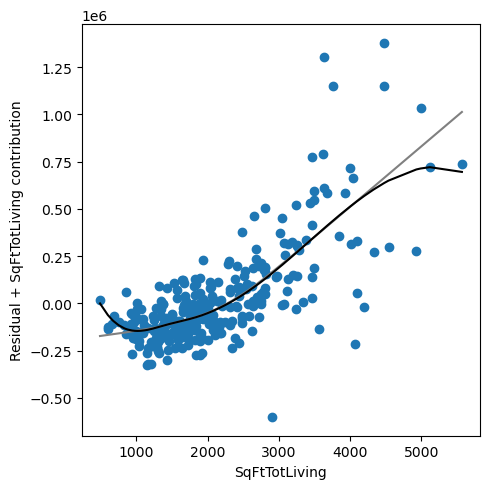

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()